# Convolutional Neural Network example

 <p>
Marie Zufferey<br>
CAS Data science - Machine learning project with TensorFlow<br>
February 2019
</p>


_multiKernel: 
=> 3 conv layers with same number of kernels (+ final layer for the output)

In [0]:
n_minibatches=10
n_epochs=100
minibatch_size=10
n_samples_valid=1000

bin_seq_len=100

valid_ratio=0.2
train_ratio=0.8

# tuned:
learning_rate = 0.001

epoch_out_step = 100 

image_file = "CNs_same_nMB" + str(n_minibatches) + "_sizeMB" + str(minibatch_size) +\
              "_nE" + str(n_epochs) + "_nVal" + str(n_samples_valid) +\
              "_LR" + str(learning_rate) + ".png"

log_file = "CNs_same_nMB" + str(n_minibatches) + "_sizeMB" + str(minibatch_size) +\
              "_nE" + str(n_epochs) + "_nVal" + str(n_samples_valid) +\
              "_LR" + str(learning_rate) + "_log.txt"

## 1. Load necessary libraries

In [17]:
# !!! HARD-CODED INPUT FOLDER NAMES HERE !!!
! tar -xzvf myutils.tar.gz
#! tar -xzvf random_chromo_data.tar.gz
! tar -xzvf cnn_data.tar.gz

import sys
import os
import math
import random
import re

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
from PIL import Image

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from myutils import gr_disp
from myutils_v2 import *
from my_cnn_functions import *

# for online def of nested dict
from collections import defaultdict
nesteddict = lambda : defaultdict(nesteddict)


from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

myutils/
myutils/gr_disp.pyc
myutils/__init__.py
myutils/inception.py
myutils/__init__.pyc
myutils/gr_disp.py
cnn_data/
cnn_data/GM12878_chr10_final_agg_fltrd.txt
cnn_data/GM12878_chr11_final_agg_fltrd.txt
cnn_data/GM12878_chr12_final_agg_fltrd.txt
cnn_data/GM12878_chr13_final_agg_fltrd.txt
cnn_data/GM12878_chr14_final_agg_fltrd.txt
cnn_data/GM12878_chr15_final_agg_fltrd.txt
cnn_data/GM12878_chr16_final_agg_fltrd.txt
cnn_data/GM12878_chr17_final_agg_fltrd.txt
cnn_data/GM12878_chr18_final_agg_fltrd.txt
cnn_data/GM12878_chr19_final_agg_fltrd.txt
cnn_data/GM12878_chr1_final_agg_fltrd.txt
cnn_data/GM12878_chr20_final_agg_fltrd.txt
cnn_data/GM12878_chr21_final_agg_fltrd.txt
cnn_data/GM12878_chr22_final_agg_fltrd.txt
cnn_data/GM12878_chr2_final_agg_fltrd.txt
cnn_data/GM12878_chr3_final_agg_fltrd.txt
cnn_data/GM12878_chr4_final_agg_fltrd.txt
cnn_data/GM12878_chr5_final_agg_fltrd.txt
cnn_data/GM12878_chr6_final_agg_fltrd.txt
cnn_data/GM12878_chr7_final_agg_fltrd.txt
cnn_data/GM12878_chr8_final

## 2. Prepare input data


In [18]:
### HARD-CODED SETTINGS FOR THE INPUT DATA:

input_folder = "cnn_data"

model_logfile = "train_model_logfile_trueData.txt"

image_file = "model_result.png"

chromo_pattern = '.*(chr.+)[_\\.].*'
col_with_BD_score = 0 # the boundary score is held in the 1st column of the DF
print("! hard-coded chromo_pattern = " + chromo_pattern)
print("! hard-coded col_with_BD_score = " + str(col_with_BD_score))


print("! hard-coded bin_seq_len = " + str(bin_seq_len))
print("! hard-coded valid_ratio = " + str(valid_ratio))
print("! hard-coded train_ratio = " + str(train_ratio))


! hard-coded chromo_pattern = .*(chr.+)[_\.].*
! hard-coded col_with_BD_score = 0
! hard-coded bin_seq_len = 100
! hard-coded valid_ratio = 0.2
! hard-coded train_ratio = 0.8


### 2a. Load and prepare input data

In [0]:
all_chromo_files = os.listdir(input_folder)

# maintain the following variables:
# (because I want to store all the data for all chromosomes in a single dataframe but I want
# to be able to perform train/validation separation in a chromosome-specific way)
chromos = []
chromos_length = {}
cumlength = 0
chromos_cumlength = {}
inputDF = None
n_chip = None

# derive chromo name from file name
for chromo_file in all_chromo_files:
  
    #print(chromo_file)
  
    match_chromo = re.match(chromo_pattern, chromo_file)
    if match_chromo == None:
      continue
    curr_chromo = match_chromo.group(1)
    chromos.append(curr_chromo)
    #print("> " + chromo_file + "\t->\t" + curr_chromo)
    chromoDF = pd.read_csv(input_folder + "/"+ chromo_file, sep="\t", header=0)
    #print(chromoDF.iloc[0:5,0:5])
    n_bins = chromoDF.shape[0]
    chromos_length[curr_chromo] = n_bins
    chromos_cumlength[curr_chromo] = cumlength
    
    cumlength += n_bins # update after: cumlength for the first chromo = 0
      
    if inputDF is None:
      inputDF = chromoDF
      n_chip = inputDF.shape[1] - 1
    else:
      assert chromoDF.shape[1] == inputDF.shape[1]
      assert chromoDF.columns.tolist() == inputDF.columns.tolist()
      inputDF = inputDF.append(chromoDF)
      
    #print("... n_bins = " + str(n_bins))
    #print("... n_chip = " + str(n_chip))

#print(chromos)

assert n_chip != None
assert not inputDF is None
assert cumlength == inputDF.shape[0]
    

### 2b. Normalization

In [20]:
### DATA NORMALIZATION
### For the input to the neural network, standardize the columns (mean=0, variance=1)

# norm_inputDF = (inputDF-inputDF.mean())/inputDF.std()
# corrected: normalize each channel separately
norm_inputDF = (inputDF-inputDF.mean(axis=0))/inputDF.std(axis=0)
print(norm_inputDF.iloc[0:5,0:5])


# chekc data frame column mean and std
assert all(norm_inputDF.mean(axis=0) < 1e-10)
assert all(norm_inputDF.std(axis=0) - 1 < 1e-10)
assert norm_inputDF.shape[1] == len(norm_inputDF.mean(axis=0) < 1e-10)

# ensure using only the norm_inputDF later on
del inputDF

   binScore  ...  ENCFF001SUE_H3K4me1
0 -0.435941  ...            -0.547291
1  0.675694  ...            -0.547291
2 -0.673768  ...            -0.547291
3 -1.111572  ...            -0.547291
4 -1.123412  ...            -0.547291

[5 rows x 5 columns]


### 2c. Split train and validation data set

In [21]:
# for each chromo
# a) retrieve # of bins
# b) retrieve valid positions (1...chr_len-bin_seq_len +1)
# c) set # of train/validation indices to sample
# d) random sample the train/validation indices
# e) recaste the indices (indices + cumsumlength)
# f) append to train/validation input dataset

# will store the list of the 1st bin position
all_train_indices = [] 
all_valid_indices = []

for chr in chromos:
  #print("> START prepare data for " + chr)
  # since I want to retrieve a sequence of bins -> need to end before the end of the chromosome...
  # and since the norm_inputDF contains all chromos -> need to shift the idx to the start of the chromo  
  chr_nbin = chromos_length[chr]
  chr_cumlen = chromos_cumlength[chr]
  chr_valid_start_positions = list(range(chr_cumlen, chr_nbin + chr_cumlen - bin_seq_len + 1))

  assert all((np.array(chr_valid_start_positions) + bin_seq_len) <= (chr_nbin + chr_cumlen))
    
  
  # !!! BUT SAMPLES WONT BE INDEPENDENT -> ONE BIN WILL BE IN MANY SAMPLES (not at middle position...)
  n_train = int(math.floor(train_ratio * len(chr_valid_start_positions)))
  n_valid = int(math.floor(valid_ratio * len(chr_valid_start_positions)))
  assert (n_train + n_valid) <= chr_nbin
  # shuffle the start indices (NB: not sure it is needed - shuffling also done before iteration over minibatches at each epoch)
  tmp = list(chr_valid_start_positions)
  random.shuffle(chr_valid_start_positions)
  assert tmp != chr_valid_start_positions # ensure shuffle is done in place...
  train_indices = chr_valid_start_positions[:n_train]
  valid_indices = chr_valid_start_positions[n_train:(n_train + n_valid)]
  
  #print("# of train indices = " + str(len(train_indices)))
  #print("# of valid indices = " + str(len(valid_indices)))
   
  all_train_indices += train_indices
  all_valid_indices += valid_indices

  
print("# of samples = " + str(norm_inputDF.shape[0]))
print("# of all_train indices = " + str(len(all_train_indices)))
print("# of all_valid indices = " + str(len(all_valid_indices)))

# since I want to retrieve a sequence of bins -> have ended before the end of each chromosome...
all_chromo_nbr_invalid_start_positions = (bin_seq_len - 1) * len(chromos)

# cannot be tested equal because of the rounding
assert (len(all_train_indices) + len(all_valid_indices)) <= (math.floor(train_ratio*
                                                                        norm_inputDF.shape[0])+
                                                             math.floor(valid_ratio * 
                                                                        norm_inputDF.shape[0]))                                                                                       

# of samples = 128394
# of all_train indices = 100964
# of all_valid indices = 25236


## 3. Define helper functions

###3.a. Function to retrieve current dataset to pass to the network for a given minibatch

In [0]:
# DEFINED IN: my_cnn_functions.py

### 3.b. Wrapper functions to build the model

In [0]:
# DEFINED IN: my_cnn_functions.py

## 4. Define the graph* (with graph.as_default(): ... )*


!!! _multiKernel: 3 layers of 16 kernels, kernels of same size (+ final layer for the output)

no maxpool

SAME padding

1x100x56
-> kernel_1: 16x (3x3x56) 
-> out_1: 1x100x16

-> kernel_2: 16x (3x3x16) 
-> out_12 1x100x16

-> kernel_3: 16x (3x3x16) 
-> out_3: 1x100x16

-> final_kernel_1: 1x (3x3x16) 
-> final_out: 1x100x1


###4.a. Hard-coded settings

In [0]:
## HARD-CODED FOR THE MODEL
dropout_keep_prob = 1    # no dropout regularization for the moment

CN1_n_filt=16
CN1_k_size=3
CN1_n_stri_conv=1
CN1_p_type="same"
CN1_activ_fct=tf.nn.relu


CN2_n_filt = CN3_n_filt = CN1_n_filt
CN2_k_size = CN3_k_size = CN1_k_size
CN2_n_stri_conv = CN3_n_stri_conv = CN1_n_stri_conv
CN2_p_type = CN3_p_type = CN1_p_type
CN2_activ_fct = CN3_activ_fct = CN1_activ_fct


finalCN_n_filt = 1
finalCN_k_size = 1
finalCN_n_stri_conv = 1
finalCN_p_type = CN1_p_type
finalCN_activ_fct = None


allCN_n_filt = [CN1_n_filt, CN2_n_filt, CN3_n_filt, finalCN_n_filt]
allCN_k_size = [CN1_k_size, CN2_k_size, CN3_k_size, finalCN_k_size]
allCN_n_stri_conv= [CN1_n_stri_conv, CN2_n_stri_conv,  CN3_n_stri_conv, finalCN_n_stri_conv]
allCN_p_type= [CN1_p_type, CN2_p_type, CN3_p_type, finalCN_p_type]
allCN_activ_fct= [CN1_activ_fct, CN2_activ_fct, CN3_activ_fct, finalCN_activ_fct]
                  
  
  
            

# ### CROPPING THE INPUT
# if p_type.lower() == "valid":
#   crop_delta =  k_size//2
#   crop_step = (mp_size)**n_MP
# elif p_type.lower() == "same":
#   crop_delta =0
#   crop_step = (mp_size)**n_MP
# else:
#   print("invalid p_type")
#   sys.exit(1)

  
# y_input_cropped = y_input[crop_delta:-crop_delta:crop_step]

# => NO MAX POOLING AND SAME PADDING => NO CROPPING NEEDED

bin_seq_len_cropped = bin_seq_len

crop_step=1

In [0]:
allCN_n_filt = 20*[CN1_n_filt] + [finalCN_n_filt]
allCN_n_filt
allCN_k_size = 20*[CN1_k_size] + [finalCN_k_size]
allCN_n_stri_conv = 20 * [CN1_n_stri_conv] + [finalCN_n_stri_conv]
allCN_p_type= 20 * [CN1_p_type] + [finalCN_p_type]
allCN_activ_fct= 20 * [CN1_activ_fct] + [finalCN_activ_fct]



CN1_n_filt = 16
CN2_n_filt = 64
CN3_n_filt = 128
CN4_n_filt = 256
CN5_n_filt = 128
CN6_n_filt = 64
CN7_n_filt = 16


allCN_n_filt = [CN1_n_filt, CN2_n_filt, CN3_n_filt,  CN4_n_filt,  CN5_n_filt,  CN6_n_filt,  CN7_n_filt, finalCN_n_filt]
allCN_k_size = 7*[CN1_k_size] + [finalCN_k_size]
allCN_n_stri_conv= 7*[CN1_n_stri_conv] + [finalCN_n_stri_conv]
allCN_p_type= 7 * [CN1_p_type] + [finalCN_p_type]
allCN_activ_fct= 7 * [CN1_activ_fct] + [finalCN_activ_fct]


###4.b. Define the model

In [26]:
print("> START constructing TF graph")

g = tf.Graph()

print("... construct placeholders")
with g.as_default():
  

  ### DEFINE INPUT PLACEHOLDERS  # -> put None instead of minibatch_size to be run with validation set !!!
  x_input = tf.placeholder(dtype = tf.float32, 
                           shape = [None, bin_seq_len, n_chip],  # [batch_size, sequence_length, num_proteins]
                           name = "x_input") 
 
  ### y_obs need to be the cropped variables !!!!!!! 
  y_obs = tf.placeholder(dtype = tf.float32, 
                         shape = [None, bin_seq_len_cropped, 1],  # [batch_size, sequence_length] or [batch_size, sequence_length, 1]
                         name  = "y_obs")
  
  minibatch_size_ = tf.placeholder(dtype = tf.int32,   # [batch_size, sequence_length] or [batch_size, sequence_length, 1]
                         name  = "minibatch_size_")

  # probability to keep the unit at regularization
  drop_keep_prob = tf.placeholder(tf.float32, name="drop_keep_prob")
  
  # learning rate
  learn_rate = tf.placeholder(tf.float32, name ="learn_rate")
  
  ### CALL THE NN TO RETRIEVE THE PREDICTIONS
  y_pred =   conv1d_model_CNs(CN_input = x_input,
                   CN_nbr_filters = allCN_n_filt,
                   CN_size_kernel = allCN_k_size,
                   CN_step_stride= allCN_n_stri_conv,
                   CN_type_padding= allCN_p_type,
                   CN_activ_function= allCN_activ_fct,
 
                  minibatch_size=minibatch_size_,          
                  bin_seq_len=bin_seq_len,
                  n_chip = n_chip
                            )

  
  ### OPTIMIZATION  
  # compute the cost -> linear function with MSE 
  loss = tf.reduce_mean(tf.square(y_obs - y_pred))

  # run the optimizer
  optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(loss)

  
    # for visualization we will calculate the gradients
    #gradients of each of bin_seq_len outputs over input x
   # yh_grad = [tf.gradients(Y_onehot[..., i], X) for i in range(10)]
    #gradient of maximal output over input x
    #ym_grad = tf.gradients(tf.reduce_max(Y_onehot, axis=1), X)

> START constructing TF graph
... construct placeholders


In [27]:

all_minibatch_avg_loss_train = []
all_epoch_loss_train = []
all_epoch_loss_valid = []

losses_train = []
losses_valid = []

# Start training
with tf.Session(graph=g) as sess:
    # Run the initializer
    sess.run(tf.global_variables_initializer())
 
    # training in 2 loops: 1) outer: over epochs; 2) for each epoch: over mini-batches (optimization for all of the minin-batches)
    # -> at the end of 1 epoch, as many optimization as mini-batches
    # !!! data should not go into training pipeline in same order !!!
    # -> at the beginning of each epoch, shuffle the indices before iterating over the mini-batches !!!
    all_epoch_avg_loss_train = []
    all_epoch_avg_loss_valid = []
    
    # Iteration over the batches
    for i_epoch in range(n_epochs):
      epoch_avg_loss_train = 0
      epoch_avg_loss_valid = 0
      
      for i_minibatch in range(n_minibatches):
        
        minibatch_x, minibatch_y = get_minibatch_xy(index_list=all_train_indices,
                                                  i_batch=i_minibatch, 
                                                  n_to_sample=minibatch_size,
                                                  full_inputDF = norm_inputDF,
                                                  y_obs_colnbr = col_with_BD_score,
                                                  seq_len = bin_seq_len) 

        x_sequence=minibatch_x

        if CN1_p_type.lower() == "same": 
          y_input_cropped=np.apply_along_axis(crop_seq, 1, minibatch_y,  mp_step=crop_step, check_size=bin_seq_len_cropped)
        else:
          print("not implemented")
          sys.exit(1)
          
        # sess.run() should be fed with all minibatch samples        
        # CALL ONLY THE OPTIMIZER !!! -> IN CASCADE, WILL RUN THE FULL GRAPH
        # Run optimization (backprop) # should have as many optimizations as mini-batches 
        # Fit training using batch data
        _, minibatch_loss = sess.run((optimizer, loss),
                  feed_dict={
                      x_input: x_sequence,
                      y_obs: y_input_cropped,
                      learn_rate: learning_rate,
                      minibatch_size_:minibatch_size
                      })

        loss_train = minibatch_loss
        losses_train.append(np.mean(loss_train))
                
        x_valid, y_valid = get_minibatch_xy(index_list=all_valid_indices,
                                  i_batch=0, 
                                  n_to_sample=n_samples_valid,  # !!!!!!!!!!!!!!!!!! WRONG HERE BUT I NEED TO UPDATE THE GRAPH MODEL DEFINITION !!!!!!!!!!!!!!!!!!,
                                  full_inputDF = norm_inputDF,
                                  y_obs_colnbr = col_with_BD_score,
                                  seq_len = bin_seq_len)   
        
        if CN1_p_type.lower() == "same": 
          y_valid_cropped=np.apply_along_axis(crop_seq, 1, y_valid,  mp_step=crop_step, check_size=bin_seq_len_cropped)
        else:
          print("not implemented")
          sys.exit(1)
          
        loss_valid = sess.run((loss),feed_dict={
                      x_input: x_valid,
                      y_obs: y_valid_cropped,
                      learn_rate: learning_rate,
                      minibatch_size_:n_samples_valid
                      })
                
        losses_valid.append(np.mean(loss_valid))

        txt = "Epoch: %03d/%03d - minibatch: %03d/%03d,  minibatch_loss_train = %.9f" % (i_epoch, n_epochs,i_minibatch, n_minibatches, loss_train)
        if not i_epoch % epoch_out_step:
          print(txt)
          print_in_file(mytext=txt, filename=log_file)
        
        txt = "Epoch: %03d/%03d - minibatch: %03d/%03d,  minibatch_loss_valid = %.9f" % (i_epoch, n_epochs,i_minibatch, n_minibatches, loss_valid)
        if not i_epoch % epoch_out_step:
          print(txt)
          print_in_file(mytext=txt, filename=log_file)


        # Add current mini-batch loss to average loss for this epoch:
        epoch_avg_loss_train += loss_train/n_minibatches
        epoch_avg_loss_valid += loss_valid/n_minibatches


      # END-For i_minibatch
      all_epoch_avg_loss_train.append(epoch_avg_loss_train)
      all_epoch_avg_loss_valid.append(epoch_avg_loss_valid)
      

Epoch: 000/100 - minibatch: 000/010,  minibatch_loss_train = 1.968889594
Epoch: 000/100 - minibatch: 000/010,  minibatch_loss_valid = 2.338384151
Epoch: 000/100 - minibatch: 001/010,  minibatch_loss_train = 2.105943441
Epoch: 000/100 - minibatch: 001/010,  minibatch_loss_valid = 2.319736481
Epoch: 000/100 - minibatch: 002/010,  minibatch_loss_train = 2.584591866
Epoch: 000/100 - minibatch: 002/010,  minibatch_loss_valid = 2.301503420
Epoch: 000/100 - minibatch: 003/010,  minibatch_loss_train = 2.516873121
Epoch: 000/100 - minibatch: 003/010,  minibatch_loss_valid = 2.283830404
Epoch: 000/100 - minibatch: 004/010,  minibatch_loss_train = 1.993777752
Epoch: 000/100 - minibatch: 004/010,  minibatch_loss_valid = 2.267160416
Epoch: 000/100 - minibatch: 005/010,  minibatch_loss_train = 2.150734425
Epoch: 000/100 - minibatch: 005/010,  minibatch_loss_valid = 2.251149416
Epoch: 000/100 - minibatch: 006/010,  minibatch_loss_train = 2.409560680
Epoch: 000/100 - minibatch: 006/010,  minibatch_los

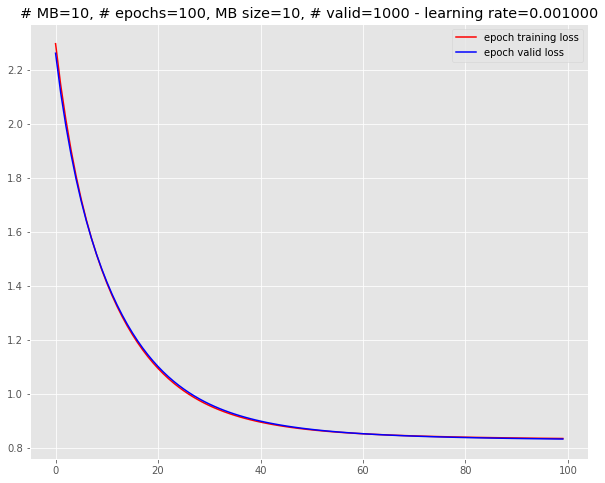

In [28]:
# PLOT LOSS    (function defined in my_cnn_functions.py)
mytit= "# MB=%d, # epochs=%d, MB size=%d, # valid=%d - learning rate=%f" % (n_minibatches, n_epochs, minibatch_size, n_samples_valid, learning_rate) 
loss_plot(train_data=all_epoch_avg_loss_train, 
          valid_data=all_epoch_avg_loss_valid, 
          plotTit = mytit,
         image_file = image_file)



In [29]:
all_epoch_avg_loss_train
all_epoch_avg_loss_valid

[2.2613207340240478,
 2.1151522397994995,
 1.9940516710281366,
 1.8887374758720399,
 1.7961036086082456,
 1.7141730666160582,
 1.641236412525177,
 1.575917088985443,
 1.5170482158660887,
 1.463680696487427,
 1.4150659799575804,
 1.3706196188926696,
 1.32987779378891,
 1.2924606084823607,
 1.2580504059791564,
 1.2263773560523987,
 1.1972077488899233,
 1.170334029197693,
 1.145569086074829,
 1.1227430939674379,
 1.1017009258270265,
 1.082300317287445,
 1.0644102811813354,
 1.0479103326797485,
 1.0326892971992492,
 1.0186446905136108,
 1.005682075023651,
 0.9937143981456757,
 0.9826614797115326,
 0.9724495589733123,
 0.9630106449127198,
 0.9542822718620302,
 0.9462071180343627,
 0.9387323915958404,
 0.9318096995353699,
 0.925394594669342,
 0.9194463729858399,
 0.9139276623725892,
 0.9088042378425599,
 0.9040446639060974,
 0.899620234966278,
 0.8955045878887176,
 0.8916735649108886,
 0.8881050825119019,
 0.8847787857055663,
 0.8816761434078216,
 0.8787799954414367,
 0.8760747730731965,
 0.

In [0]:
def loss_plot(train_data, valid_data, image_file=None, plotTit=None):

  import matplotlib.pyplot as plt

  import numpy as np

  fig, axs = plt.subplots(1, 1, figsize=(10,8))
  ep_arr = np.arange(len(train_data))
  # axs.plot(ep_arr, all_epoch_loss_train, 'r')
  # axs.legend(('training loss'),  loc='upper right')
  axs.plot(ep_arr, train_data, 'r', ep_arr, valid_data, 'b')
  axs.legend(('epoch training loss', 'epoch valid loss'),  loc='upper right')

  if plotTit:
    plt.title(plotTit)
  if image_file:
    fig.savefig(image_file)   # save the figure to file
